<a href="https://colab.research.google.com/github/cheredi/Semantic-Resume-Matching-Using-Synthetic-Resumes-and-Embedding-Techniques/blob/main/AMUGO_1311278.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Resume Matching Using Synthetic Resumes and Embedding Techniques

### Load the Libraries

In [ ]:
# Load Libraries
import pandas as pd
import numpy as np
import random
import nltk
import spacy
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Define Model

In [ ]:
nlp= spacy.load("en_core_web_lg")

In [ ]:
#Load the Dataset
df=pd.read_csv("job_title_des.csv")

In [ ]:
df = df[['Job Title', 'Job Description']].dropna()
df.head()

,Job Title,Job Description
0,Flutter Developer,We are looking for hire experts flutter develo...
1,Django Developer,PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...
2,Machine Learning,"Data Scientist (Contractor)\n\nBangalore, IN\n..."
3,iOS Developer,JOB DESCRIPTION:\n\nStrong framework outside o...
4,Full Stack Developer,job responsibility full stack engineer – react...


In [ ]:
df.info() #More information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job Title        2277 non-null   object
 1   Job Description  2277 non-null   object
dtypes: object(2)
memory usage: 35.7+ KB


The `.info()` method provides a concise summary of the dataset, including the number of entries, column names, data types, and count of non-null values. It helps verify the integrity of the dataset and confirms that there are no missing values in the 'Job Title' and 'Job Description' fields before proceeding with preprocessing.

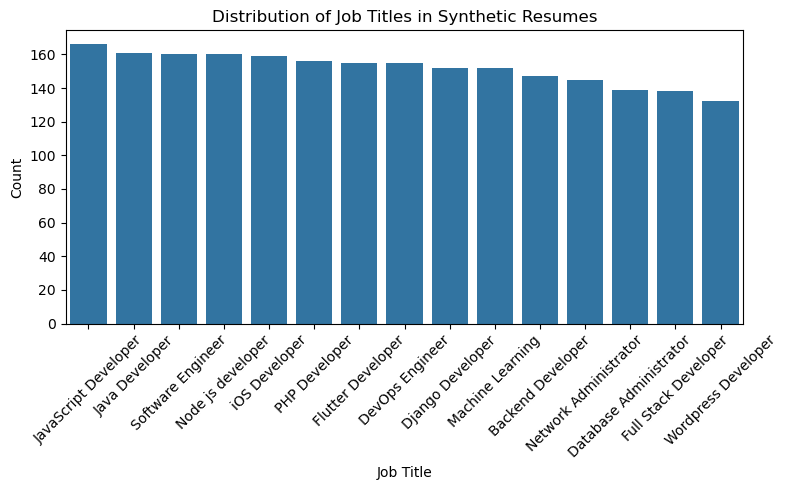

In [ ]:
#Distribution of job titles using countplot
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Job Title', order=df['Job Title'].value_counts().index)
plt.title('Distribution of Job Titles in Synthetic Resumes')
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The countplot shows the frequency of job titles within the dataset. This visualization helps identify the most common job roles and supports informed decisions when selecting target roles for synthetic resume generation. It also ensures class distribution is considered in downstream modeling.


In [ ]:
# Filter for your 3 target roles
target_job = ["Machine Learning", "Software Engineer", "Database Administrator"]
df = df[df['Job Title'].isin(target_job)].reset_index(drop=True)

## Synthetic Resume Generator

In [ ]:

# Job titles
target_jobs = ["Machine Learning", "Software Engineer", "Database Administrator"]

# Resume templates for each job
resume_templates = {
    "Machine Learning": [
        "Experienced ML engineer with {years}+ years building models using {tools}. Holds a degree in {degree}.",
        "Skilled in machine learning, deep learning, and data wrangling. {years} years of experience with {tools}. {cert}.",
        "Driven ML specialist proficient in {tools}. Bachelor's in {degree}, {years}+ years experience in AI development.",
    ],
    "Software Engineer": [
        "Full-stack developer with {years}+ years in {tools}. Built scalable apps using {frameworks}.",
        "Software engineer specializing in backend systems. Experienced with {tools} and cloud platforms like AWS.",
        "Coder with expertise in {tools}. {years}+ years developing production-ready apps. Degree in {degree}.",
    ],
    "Database Administrator": [
        "Certified {cert} with over {years} years managing SQL/NoSQL databases. Skilled in {tools}.",
        "Experienced DBA with strong background in {tools}, data backups, and performance tuning.",
        "Database administrator with {years} years’ experience in {industry}. Proven success in ensuring database uptime.",
    ]
}

# Random lists for insertion
tools_list = {
    "Machine Learning": ["Python", "TensorFlow", "PyTorch", "Scikit-learn", "Keras"],
    "Software Engineer": ["Python", "Java", "C++", "JavaScript", "Go", "TypeScript"],
    "Database Administrator": ["MySQL", "PostgreSQL", "MongoDB", "Oracle", "SQL Server"]
}

frameworks = ["React", "Django", "Flask", "Node.js", "Spring"]
degrees = ["Statistics", "Computer Science", "Data Science", "Information Systems"]
certs = ["PMP", "Scrum Master", "Agile Coach", "CAPM"]
industries = ["tech", "finance", "healthcare", "government", "education"]

def generate_resume(job_title):
    template = random.choice(resume_templates[job_title])
    years = random.randint(1, 15)
    tools = ', '.join(random.sample(tools_list[job_title], k=2))
    framework = random.choice(frameworks)
    degree = random.choice(degrees)
    cert = random.choice(certs)
    industry = random.choice(industries)

    return template.format(
        years=years,
        tools=tools,
        frameworks=framework,
        degree=degree,
        cert=cert,
        industry=industry
    )


# Generate 2000 synthetic resumes
resumes = pd.DataFrame({
    'Job Title': random.choices(target_jobs, k=2000)
})
resumes['Resume Text'] = resumes['Job Title'].apply(generate_resume)

# Optional: Preview
print(resumes.sample(5))


              Job Title                                        Resume Text
1933  Software Engineer  Coder with expertise in Go, C++. 15+ years dev...
461   Software Engineer  Software engineer specializing in backend syst...
1806  Software Engineer  Full-stack developer with 12+ years in Java, T...
1414   Machine Learning  Experienced ML engineer with 15+ years buildin...
139    Machine Learning  Experienced ML engineer with 8+ years building...


The resume generator creates synthetic resumes using pre-defined role-based templates for selected job categories. Each generated resume reflects relevant skills, tools, and qualifications typically expected in that role. This approach enables controlled experimentation in job-resume matching without relying on sensitive or proprietary data.


## First Cleaning Approach

In [ ]:
#Define cleaning process

#Convert to lowercase
resumes['Lower'] = resumes['Resume Text'].str.lower()

#Parse ith spaCy
resumes['Doc'] = resumes['Lower'].apply(nlp)

#Remove Stop Words
resumes['No_stop_words'] = resumes['Doc'].apply(
    lambda doc: ' '.join([token.text for token in doc if not token.is_stop])
)

#Remove punctuation and digits
resumes['Alpha_Only'] = resumes['Doc'].apply(
    lambda doc:' '.join([token.text for token in doc if token.is_alpha and not token.is_punct])
)

In [ ]:
#Apply processing
resumes[['Resume Text', 'No_stop_words', 'Alpha_Only']].head()

,Resume Text,No_stop_words,Alpha_Only
0,Experienced ML engineer with 7+ years building...,experienced ml engineer 7 + years building mod...,experienced ml engineer with years building mo...
1,Software engineer specializing in backend syst...,software engineer specializing backend systems...,software engineer specializing in backend syst...
2,"Coder with expertise in Python, TypeScript. 2+...","coder expertise python , typescript . 2 + year...",coder with expertise in python typescript year...
3,Certified Agile Coach with over 13 years manag...,certified agile coach 13 years managing sql / ...,certified agile coach with over years managing...
4,Experienced ML engineer with 1+ years building...,experienced ml engineer 1 + years building mod...,experienced ml engineer with years building mo...


## Second cleaning Approach

- **POS**: Part-of-Speech
- **NER**: Named Entity Recognition
- **ADJ**: Adjective
- **NOUN**: Noun
- **Lemmatized**: Words reduced to base/root form
- **POS_Nouns_Adjs**: POS-filtered text (nouns and adjectives only)
- **NER_Text**: Entities extracted without labels
- **NER_Labeled**: Named entities with type labels (e.g., PERSON, ORG)
- **Fine_POS_Tags**: Detailed grammatical tags from spaCy (e.g., `NN`, `VBZ`)


In [ ]:
#Defining the function

def preprocessing_clean(text):
    doc=nlp(text)
    lemmatization = []
    pos_tags = []
    fine_pos_tags=[]

    for token in doc:
        #Lemmatization
        lemmatization.append(token.lemma_)
        if token.pos_ in ["NOUN", "ADJ"]:
            pos_tags.append(token)
        #Collect fine-grained POS tags
        fine_pos_tags.append((token.text, token.tag_))
    lemmatization = ' '.join(lemmatization)
    pos_tags=' '.join([str(token) for token in pos_tags])

    #Named Entity Reognition
    entities_label = [(entity.text, entity.label_) for entity in doc.ents]
    entities = ' '.join(entity[0] for entity in entities_label)
    ner=[entities, entities_label]

    return pd.Series([
        lemmatization,
        pos_tags,
        ner[0],
        ner[1],
        fine_pos_tags
    ])

In [ ]:
#Apply processing
resumes[['Lemmatized', 'POS_Nouns_Adjs', 'NER_Text', 'NER_Labeled', 'Fine_POS_Tags']] = resumes['Resume Text'].apply(preprocessing_clean)

In [ ]:
#See sample output
resumes.loc[0, 'Lemmatized']
resumes.loc[0, 'POS_Nouns_Adjs']
resumes.loc[0, 'NER_Text']
resumes.loc[0, 'NER_Labeled']
resumes.loc[0, 'Fine_POS_Tags']


[('Experienced', 'JJ'),
 ('ML', 'NNP'),
 ('engineer', 'NN'),
 ('with', 'IN'),
 ('7', 'CD'),
 ('+', 'CD'),
 ('years', 'NNS'),
 ('building', 'NN'),
 ('models', 'NNS'),
 ('using', 'VBG'),
 ('TensorFlow', 'NNP'),
 (',', ','),
 ('Scikit', 'NN'),
 ('-', 'HYPH'),
 ('learn', 'NN'),
 ('.', '.'),
 ('Holds', 'VBZ'),
 ('a', 'DT'),
 ('degree', 'NN'),
 ('in', 'IN'),
 ('Computer', 'NNP'),
 ('Science', 'NNP'),
 ('.', '.')]

### Clean the job descriptions using the pre-defined cleaning methods

In [ ]:
# Lowercase and apply spaCy
df['Lower'] = df['Job Description'].str.lower()
df['Doc'] = df['Lower'].apply(nlp)

# Apply lemmatization-based cleaning
df['Lemmatization'] = df['Doc'].apply(lambda doc: ' '.join([token.lemma_ for token in doc]))


Two distinct text preprocessing approaches were implemented:
- The **first approach** used basic spaCy-based preprocessing: lowercasing, stop word removal, and punctuation filtering. This prepares text for standard vectorization.
- The **second approach** applied more advanced linguistic features using spaCy’s pipeline. It included lemmatization, POS tagging, fine-grained POS extraction, and named entity recognition (NER). This method enriches text representation by preserving contextual and grammatical information, making it suitable for deep embedding methods like BERT.


## WordCloud visualizations

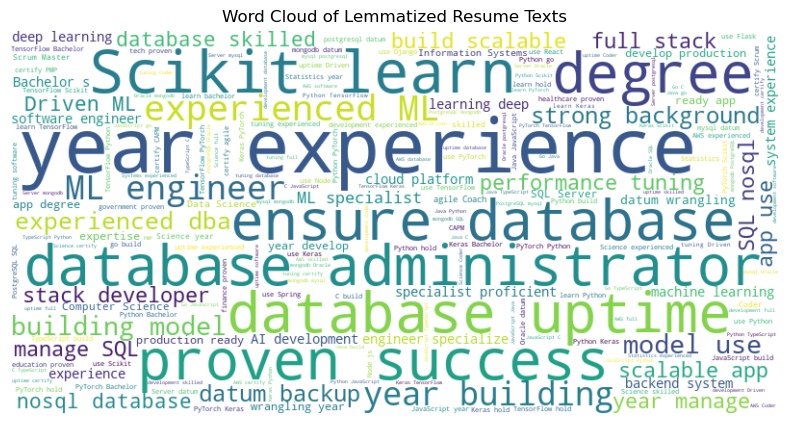

In [ ]:
#Wordcloud for resumes
text = ' '.join(resumes['Lemmatized'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Lemmatized Resume Texts')
plt.show()


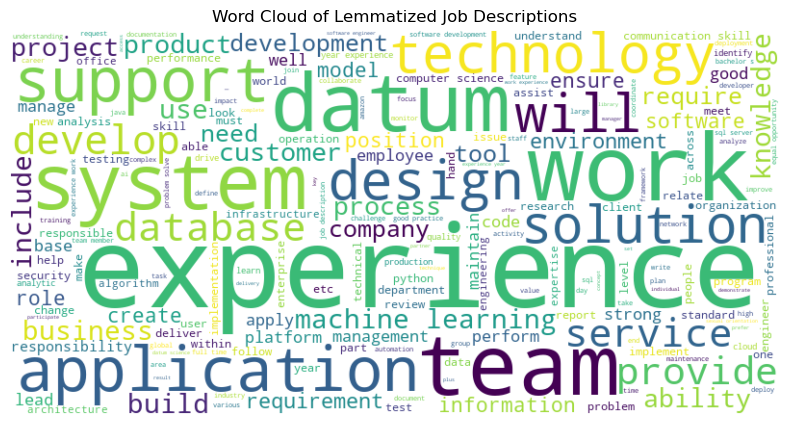

In [ ]:
#Wordcloud for job descriptions
text = ' '.join(df['Lemmatization'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Lemmatized Job Descriptions')
plt.show()


Word clouds are used to visually represent the most frequent terms in job descriptions and resumes. Larger words appear more often in the corpus. This visualization helps explore the dominant keywords in each document type, giving intuitive insight into vocabulary overlap between resumes and job postings.


## Word Embedding comparisons

### Spacy Embeddings

In [ ]:
#Define the function
def get_spacy_vector(text):
    return nlp(text).vector
#Vectorize resumes
resumes['spacy_vec'] = resumes['Resume Text'].apply(get_spacy_vector)
#Vectorize job descriptions
df['spacy_vec'] = df['Job Description'].apply(get_spacy_vector)


### Word2Vec

In [ ]:
# Train the Word2Vec model on all resume and job description text
tokenized_texts = resumes['Lemmatized'].dropna().apply(str.split).tolist() + df['Lemmatization'].dropna().apply(str.split).tolist()
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

#Function to average word vectors for a resume
def get_avg_w2v(text):
    tokens = text.split()
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

resumes['w2v_vec'] = resumes['Lemmatized'].apply(get_avg_w2v)
df['w2v_vec'] = df['Lemmatization'].apply(get_avg_w2v)


### BERT

In [ ]:
#Load pre-trained model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

#define function
def get_bert_vector(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

resumes['bert_vec'] = resumes['Resume Text'].apply(get_bert_vector)
df['bert_vec'] = df['Job Description'].apply(get_bert_vector)


### Comparisons

In [ ]:
 #Get the vectors
res_vecs = np.stack(resumes.loc[:2000, 'spacy_vec'].values)
job_vecs = np.stack(df.loc[:2000, 'spacy_vec'].values)

sim_matrix_spacy = cosine_similarity(res_vecs, job_vecs)
print(F" SPACY VECTORS")
print(sim_matrix_spacy)

# Word2Vec
res_vecs_w2v = np.stack(resumes.loc[:2000, 'w2v_vec'].values)
job_vecs_w2v = np.stack(df.loc[:2000, 'w2v_vec'].values)
sim_matrix_w2v = cosine_similarity(res_vecs_w2v, job_vecs_w2v)
print(F" WORD2VEC VECTORS")
print(sim_matrix_w2v)
# BERT
res_vecs_bert = np.stack(resumes.loc[:2000, 'bert_vec'].values)
job_vecs_bert = np.stack(df.loc[:2000, 'bert_vec'].values)
sim_matrix_bert = cosine_similarity(res_vecs_bert, job_vecs_bert)
print(F" BERT VECTORS")
print(sim_matrix_bert)

 SPACY VECTORS
[[0.91341364 0.8931245  0.8318033  ... 0.881287   0.84138453 0.89106977]
 [0.8467295  0.85496604 0.8043334  ... 0.8291282  0.7993311  0.80890876]
 [0.91545486 0.90055144 0.83390194 ... 0.8896042  0.8525664  0.88279843]
 ...
 [0.8859884  0.89434075 0.83687663 ... 0.8699562  0.8381586  0.85539776]
 [0.70496106 0.71550447 0.7026689  ... 0.69991934 0.7167278  0.6794441 ]
 [0.9382842  0.915279   0.81915474 ... 0.9052993  0.8625202  0.90896624]]
 WORD2VEC VECTORS
[[0.9202391  0.88617426 0.71558076 ... 0.8642603  0.743047   0.8737873 ]
 [0.9152018  0.9193675  0.7206324  ... 0.8869407  0.7535444  0.8851226 ]
 [0.86723584 0.848655   0.73457956 ... 0.8097016  0.75651795 0.84139085]
 ...
 [0.9172653  0.92063504 0.7184803  ... 0.88971853 0.751579   0.88677216]
 [0.78120625 0.76140726 0.8141062  ... 0.7207514  0.80814946 0.7069764 ]
 [0.9517906  0.88346565 0.64541954 ... 0.883663   0.67718524 0.84574324]]
 BERT VECTORS
[[0.81209016 0.7390107  0.67922026 ... 0.7662915  0.6194638  0.78

I compared resumes and job descriptions using cosine similarity across three embedding methods: spaCy, Word2Vec, and BERT. Word2Vec produced the highest similarity scores (up to ~0.97), reflecting strong alignment based on domain-specific terms and frequent co-occurrences. spaCy also showed consistently high scores (0.72–0.93), making it efficient for capturing general semantic overlap. In contrast, BERT yielded lower scores overall (0.60–0.84) but is better at identifying true contextual relevance between a resume and job description.

The differences reflect each model's strengths: Word2Vec excels in term-matching, spaCy offers lightweight semantic comparison, and BERT provides deeper contextual insight. While Word2Vec may overestimate similarity due to lack of context, BERT’s lower scores are more conservative and meaningful. This combination of methods provides a fuller picture of how well each resume aligns with target roles.

Cosine similarity measures the angle between document vectors, indicating how similar two texts are regardless of their length. A value closer to 1 indicates high similarity. In this project, cosine similarity matrices were computed for each embedding method to evaluate how closely each resume matches each job description. These scores were used to compare semantic effectiveness across spaCy vectors, Word2Vec, and BERT.


### Visualizations to show comparisons

In [ ]:
# Combine vectors and labels for spaCy
combined_spacy = np.vstack((res_vecs, job_vecs))
labels_spacy = ['Resume'] * len(res_vecs) + ['Job'] * len(job_vecs)
titles_spacy = [f"R{i+1}" for i in range(len(res_vecs))] + [f"J{i+1}" for i in range(len(job_vecs))]

# Word2Vec
combined_w2v = np.vstack((res_vecs_w2v, job_vecs_w2v))
labels_w2v = ['Resume'] * len(res_vecs_w2v) + ['Job'] * len(job_vecs_w2v)
titles_w2v = [f"R{i+1}" for i in range(len(res_vecs_w2v))] + [f"J{i+1}" for i in range(len(job_vecs_w2v))]

# BERT
combined_bert = np.vstack((res_vecs_bert, job_vecs_bert))
labels_bert = ['Resume'] * len(res_vecs_bert) + ['Job'] * len(job_vecs_bert)
titles_bert = [f"R{i+1}" for i in range(len(res_vecs_bert))] + [f"J{i+1}" for i in range(len(job_vecs_bert))]


### PCA

In [ ]:
def plot_pca(embeddings, labels, titles=None, title="PCA - Resume vs Job Description"):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, s=100, palette="Set2")

    if titles:
        for i, txt in enumerate(titles):
            plt.annotate(txt, (reduced[i, 0]+0.01, reduced[i, 1]+0.01), fontsize=0.5)

    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()


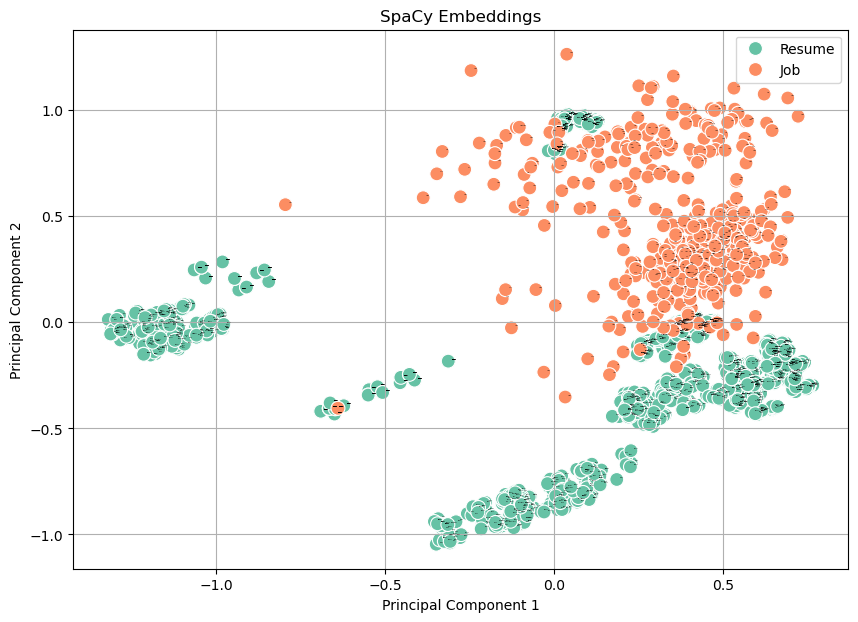

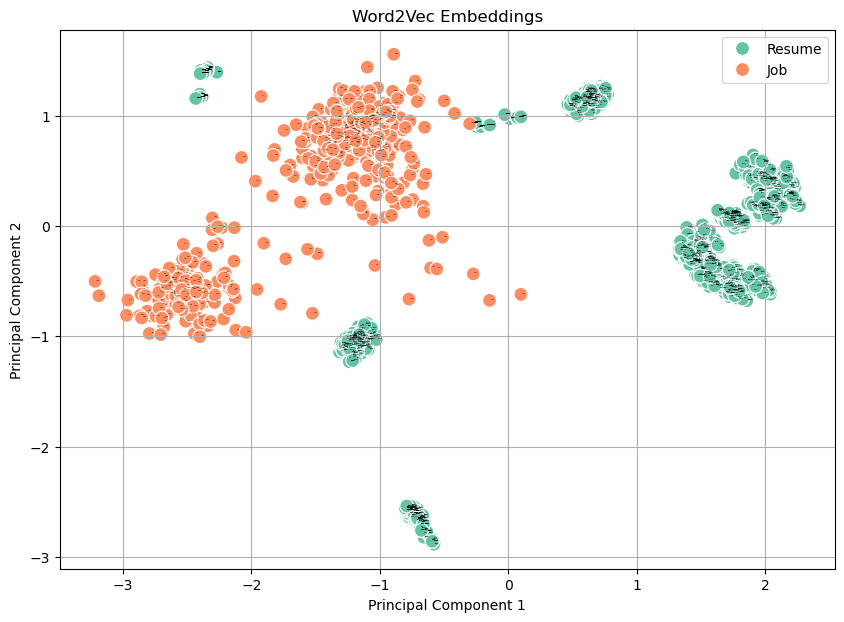

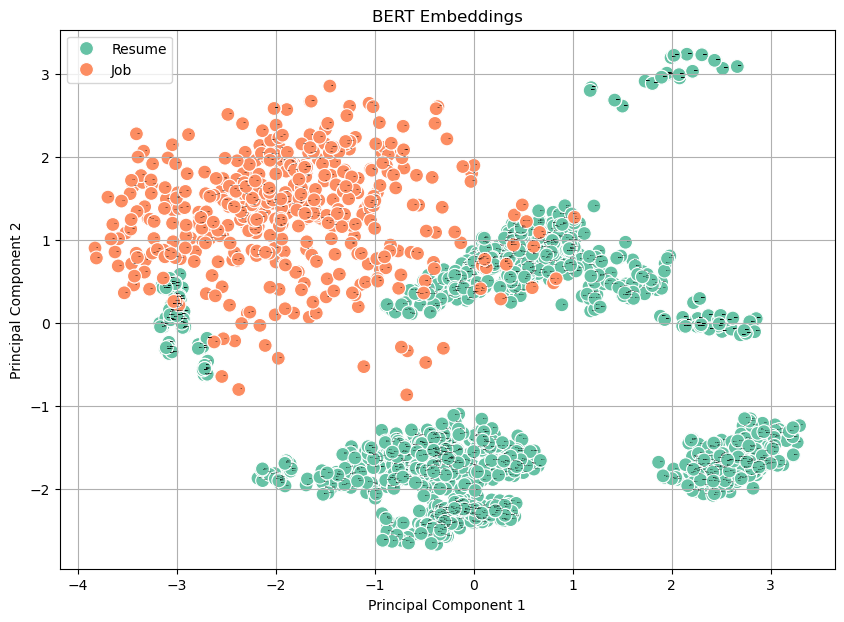

In [ ]:
#Plot the PCA
plot_pca(combined_spacy, labels_spacy, titles_spacy, title="SpaCy Embeddings")
plot_pca(combined_w2v, labels_w2v, titles_w2v, title="Word2Vec Embeddings")
plot_pca(combined_bert, labels_bert, titles_bert, title="BERT Embeddings")

In the above PCA plots, I observed distinct clustering patterns across the three embedding methods. For the spaCy embeddings, the green points (representing resumes) are somewhat intermixed with the orange points (job descriptions), with a few resumes closely surrounding specific job descriptions. This indicates some semantic overlap, though a number of resumes remain dispersed. With Word2Vec, the separation becomes more pronounced—most resumes are grouped distinctly apart from the job descriptions, with only a few showing proximity. This suggests that Word2Vec embeddings captured less contextual similarity between the two text types. In contrast, the BERT-based embeddings show improved alignment: more resumes are located closer to the job descriptions, though some still form distinct clusters. This highlights BERT's strength in capturing contextual semantics, reflecting a greater degree of similarity between certain resumes and corresponding job descriptions.

Principal Component Analysis (PCA) is used here to reduce the dimensionality of word embeddings (spaCy, Word2Vec, and BERT) to 2D space for visualization. It helps illustrate the semantic relationship between resumes and job descriptions by projecting high-dimensional vectors into clusters. Closer points suggest higher semantic similarity. Comparing the spread and overlap of resumes and job descriptions reveals how well each embedding method captures job-role relevance.


### T-SNE

In [ ]:
def plot_tsne_fast(embeddings, labels, titles, title=""):
    reducer = TSNE(n_components=2, perplexity=5, init="pca", learning_rate="auto", n_iter=250, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, s=100, palette="Set2")

    for i, txt in enumerate(titles):
        plt.annotate(txt, (reduced[i, 0] + 0.005, reduced[i, 1] + 0.005), fontsize=0.5)

    plt.title(f"t-SNE Plot - {title}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()


/Users/tatyanaamugo/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


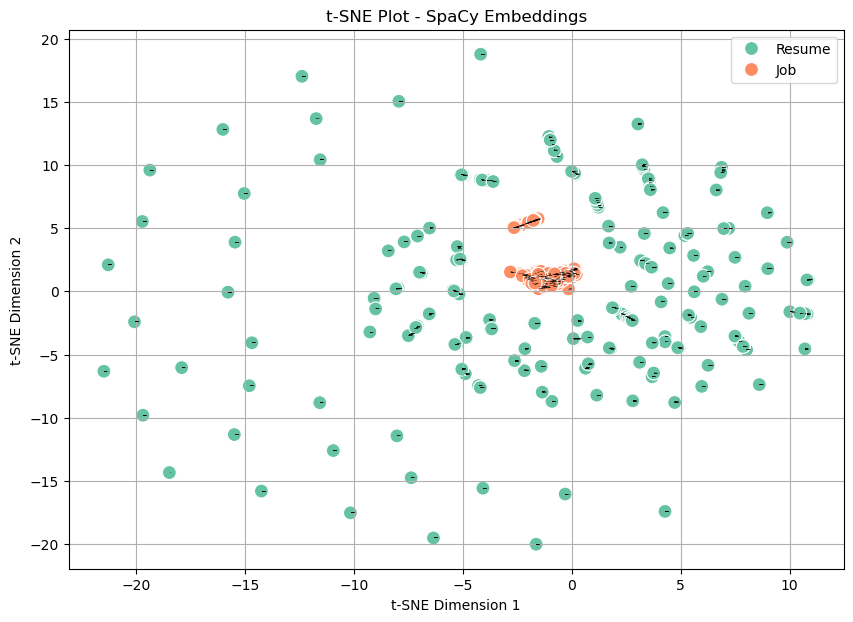

/Users/tatyanaamugo/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


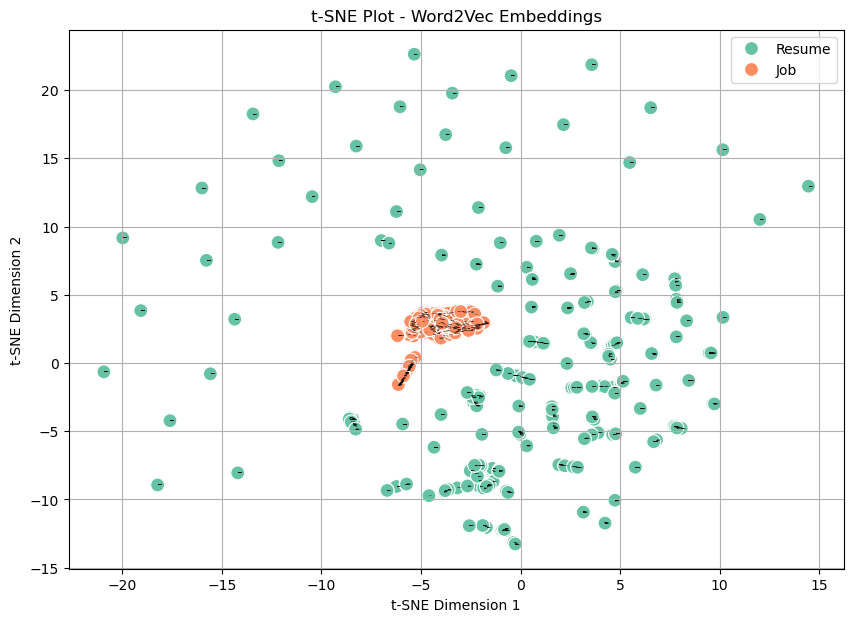

/Users/tatyanaamugo/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


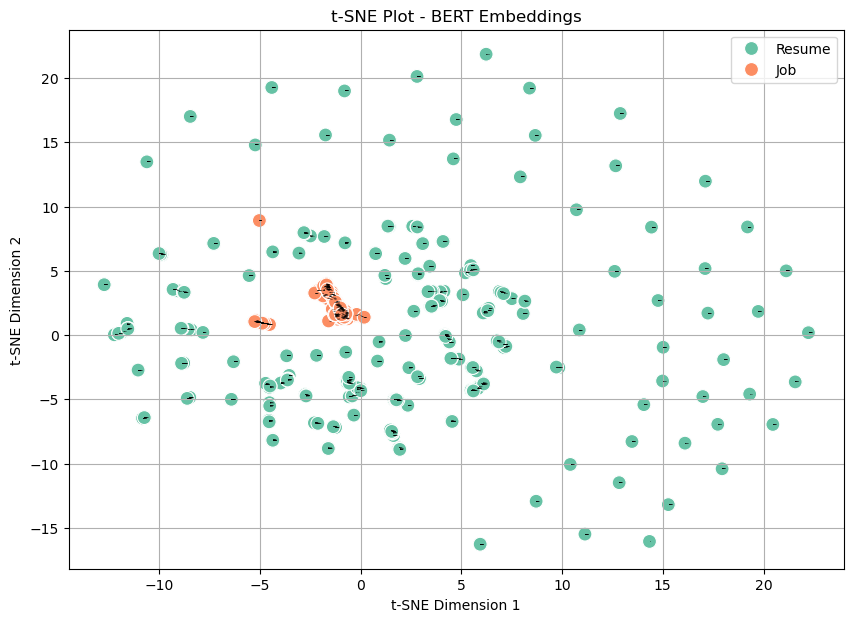

In [ ]:
#T-SNE
plot_tsne_fast(combined_spacy, labels_spacy, titles_spacy, title="SpaCy Embeddings")
plot_tsne_fast(combined_w2v, labels_w2v, titles_w2v, title="Word2Vec Embeddings")
plot_tsne_fast(combined_bert, labels_bert, titles_bert, title="BERT Embeddings")

The t-SNE plots offer deeper insights into how each embedding method captures relationships between resumes (green) and job descriptions (orange). For the spaCy embeddings, the green points appear widely dispersed, with minimal clustering, though some resumes are positioned near job descriptions—suggesting sporadic semantic alignment. In the Word2Vec visualization, the spread is more compact and the distance between resumes and job descriptions is reduced compared to spaCy. Although the grouping is less distinct, a noticeable number of resumes are still located near the orange points, indicating a moderate level of similarity. Finally, in the BERT-based embeddings, the distribution is more uniform, and the green points form more coherent clusters. The proximity between resumes and job descriptions is generally closer than in the other two methods, demonstrating BERT’s stronger ability to capture semantic relationships across diverse text

t-SNE is a nonlinear dimensionality reduction technique that captures local similarities and reveals cluster structures in high-dimensional data. It is especially useful for visualizing subtle differences between embeddings. In this project, t-SNE helps show how resumes and job descriptions are grouped in embedding space, allowing deeper interpretation of which method (spaCy, Word2Vec, or BERT) better aligns resumes with their corresponding job roles.


# Report

## Project Overview

This project focuses on automating and evaluating resume-to-job matching using synthetic resume generation, text cleaning techniques, and word embedding methods. I aim to simulate a real-world resume matching system by leveraging NLP pipelines to align job descriptions with generated resumes.

I used a job dataset with 2,277 job descriptions and selected three roles: Machine Learning Engineer, Software Engineer, and Database Administrator. Using this as a reference, 2,000 synthetic resumes were generated using structured templates with randomized years of experience, technical tools, degrees, and certifications.

## Data Preparation

## Text Preprocessing Approaches

**First Approach: Lightweight spaCy Pipeline**
I Converted text to lowercase. Then removed stop words and punctuation.I proceeded to use spaCy to tokenize and parse the text.Then I extracted alphabetic tokens only.

**Second Approach: spaCy Pipeline**
I did tokenization and lemmatization using spaCy.I proceeded to do POS tagging (with focus on NOUN and ADJ).Then i did Fine-grained POS tags (e.g., NN, VBZ) collected via token.tag_.Finally finished with,Named Entity Recognition (NER) extracted both labeled and raw entities.

These preprocessing approaches ensured that the text was standardized and enriched for semantic modeling.

## Word Embedding Methods

### spaCy Vectors

Represented each document using pre-trained en_core_web_lg spaCy word vectors averaged across tokens. These vectors captured basic semantic relationships but lacked deep contextual understanding.

### Word2Vec

Trained a gensim Word2Vec model on tokenized text from resumes and job descriptions.It averaged word vectors for each document.Then provided context-aware embeddings based on local co-occurrence.

### BERT

Used HuggingFace’s bert-base-uncased model via transformers.Encoded each text using [CLS] token embeddings (mean-pooled from hidden states).Delivered rich contextual embeddings.

## Similarity Analysis

Using cosine similarity, I computed how close each resume was to each job description across all three methods:

**Word2Vec** showed the highest similarity scores (~0.97), ideal for matching based on common vocabulary.

**spaCy embeddings** were moderately strong (~0.72–0.93), highlighting semantic overlap.

**BERT** had conservative scores (~0.60–0.84), reflecting deeper contextual understanding over surface-level term matching.

## Visual Comparison Using PCA and t-SNE

### PCA Observations

**spaCy:** Green points (resumes) partially overlapped orange points (jobs), with some distinct clusters, indicating moderate alignment.

**Word2Vec:** Resumes were largely separated from job descriptions, indicating limited deep context similarity.

**BERT:** Clusters of resumes appeared closer to job descriptions, showing better semantic matching.

### t-SNE Observations

**spaCy:** Resumes were scattered, with some overlapping job descriptions.

**Word2Vec:** Resumes formed more compact clusters with some close to jobs, though alignment was inconsistent.

**BERT:** The most uniform and semantically aligned clusters, with resume vectors frequently near job vectors.

These visualizations supported the numerical results by providing spatial confirmation of semantic closeness.

## Conclusion

This project demonstrated that deep contextual embeddings like BERT outperform traditional models in semantic resume screening. While Word2Vec performed well in measuring surface-level semantic similarity, BERT's understanding of sentence context made it a better candidate for real-world recruitment systems. In the future, incorporating experience length, education, and multi-sentence modeling could further refine matching accuracy.

## References


- Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805). *arXiv preprint arXiv:1810.04805*.

- Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781). *arXiv preprint arXiv:1301.3781*.

- Reimers, N., & Gurevych, I. (2019). [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/abs/1908.10084). *arXiv preprint arXiv:1908.10084*.

- Honnibal, M., & Montani, I. (2020). [spaCy 2: Natural Language Understanding with Bloom Embeddings, Convolutional Neural Networks and Incremental Parsing](https://spacy.io). *spaCy Documentation*.

- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). [Scikit-learn: Machine Learning in Python](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html). *Journal of Machine Learning Research, 12*, 2825–2830.

- Regmi, K. (2023). [Jobs and Job Descriptions Dataset](https://www.kaggle.com/datasets/kshitizregmi/jobs-and-job-description). *Kaggle Datasets*.